# Configurações Iniciais

In [66]:
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
from torchvision import models
import random
import torch
from collections import Counter
from torchvision.utils import make_grid

import os

def set_seed(seed=1234):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("device:", device)
print("cuda disponível?", torch.cuda.is_available())

device: cuda:0
cuda disponível? True


# Preparação do Dataset

In [67]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [68]:
data_root = os.path.join(path, "Data")
base_dataset = datasets.ImageFolder(data_root)

print("Classes encontradas:", base_dataset.classes)

Classes encontradas: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [69]:
# ---------- transforms ----------
img_size = (224, 224)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(
        [transforms.RandomRotation(5)],
        p=0.5
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [70]:
# ---------- split treino / validação / teste ----------
torch.manual_seed(42)

total_len = len(base_dataset)

# 20% para TESTE (nunca usado no treinamento)
test_size = int(0.2 * total_len)
train_val_size = total_len - test_size  # 80%

# primeiro: separa train+val de test
train_val_subset, test_subset = random_split(
    base_dataset,
    [train_val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# agora, dentro de train_val, separa TREINO e VALIDAÇÃO
val_ratio = 0.2                 # 20% de validação dentro dos 80%
val_size  = int(val_ratio * train_val_size)
train_size = train_val_size - val_size

train_subset, val_subset = random_split(
    train_val_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(123)
)

print(f"Tamanho treino (full): {len(train_subset)}")
print(f"Tamanho validação (full): {len(val_subset)}")
print(f"Tamanho teste (full): {len(test_subset)}")

print("\nÍndice -> nome da classe:")
for idx, name in enumerate(base_dataset.classes):
    print(idx, "->", name)

Tamanho treino (full): 37824
Tamanho validação (full): 9456
Tamanho teste (full): 11819

Índice -> nome da classe:
0 -> Angry
1 -> Fear
2 -> Happy
3 -> Sad
4 -> Suprise


In [71]:
# ---------- mini-dataset de debug ----------
from collections import Counter
from torch.utils.data import Subset  # já deve estar importado no topo, mas deixei aqui por garantia

# limites máximos para cada conjunto no modo debug
MAX_TRAIN = 5000
MAX_VAL   = 3000
MAX_TEST  = 3000

max_train = min(MAX_TRAIN, len(train_subset))
max_val   = min(MAX_VAL,   len(val_subset))
max_test  = min(MAX_TEST,  len(test_subset))

torch.manual_seed(123)  # para repetibilidade

train_idx = torch.randperm(len(train_subset))[:max_train]
val_idx   = torch.randperm(len(val_subset))[:max_val]
test_idx  = torch.randperm(len(test_subset))[:max_test]

train_subset_debug = Subset(train_subset, train_idx)
val_subset_debug   = Subset(val_subset,   val_idx)
test_subset_debug  = Subset(test_subset,  test_idx)

print(f"\nTamanho treino (debug): {len(train_subset_debug)}")
print(f"Tamanho validação (debug): {len(val_subset_debug)}")
print(f"Tamanho teste (debug): {len(test_subset_debug)}")

def contar_labels(subset):
    labels = []
    for i in range(len(subset)):
        _, label = subset[i]
        labels.append(label)
    return Counter(labels)

print("\nDistribuição no treino (debug):", contar_labels(train_subset_debug))
print("Distribuição na validação (debug):", contar_labels(val_subset_debug))
print("Distribuição no teste (debug):", contar_labels(test_subset_debug))


Tamanho treino (debug): 5000
Tamanho validação (debug): 3000
Tamanho teste (debug): 3000

Distribuição no treino (debug): Counter({2: 1594, 3: 1041, 1: 848, 0: 822, 4: 695})
Distribuição na validação (debug): Counter({2: 925, 3: 632, 0: 528, 1: 483, 4: 432})
Distribuição no teste (debug): Counter({2: 903, 3: 665, 0: 536, 1: 474, 4: 422})


In [72]:
# ---------- wrapper + loaders ----------
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# aqui você escolhe usar os subsets "debug" em vez dos full
use_debug = True

if use_debug:
    train_base = train_subset_debug
    val_base   = val_subset_debug
    test_base  = test_subset_debug
else:
    train_base = train_subset
    val_base   = val_subset
    test_base  = test_subset

train_dataset = SubsetWithTransform(train_base, transform=transform_train)
val_dataset   = SubsetWithTransform(val_base,   transform=transform_test)
test_dataset  = SubsetWithTransform(test_base,  transform=transform_test)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
testloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

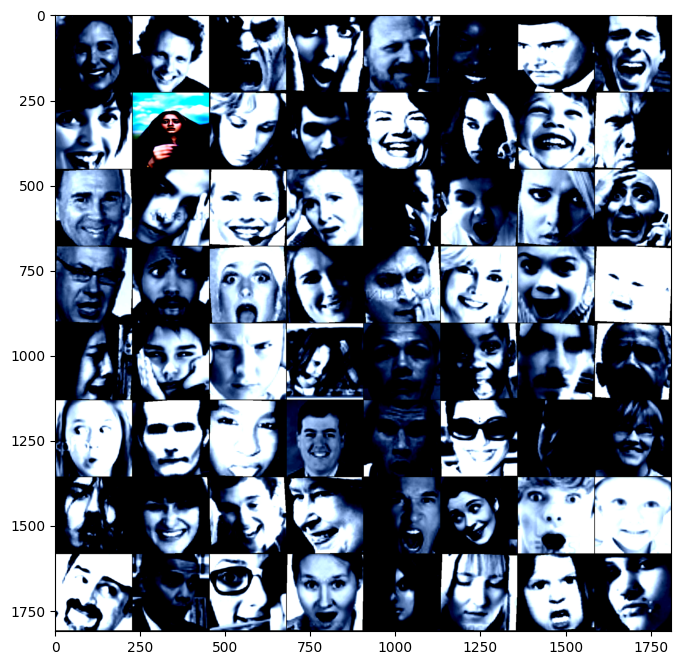

In [73]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(make_grid(images[0]))

# Treinando o Modelo

## Métodos Gerais: Treinamento, Validação, Acurácia, Matriz de Confusão

In [74]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, valloader, optimizer, criterion, epochs,
          scheduler=None, early_stopping_patience=None):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        val_loss = validation(model, valloader, criterion)

        # scheduler (ReduceLROnPlateau usa val_loss)
        if scheduler is not None:
            scheduler.step(val_loss)

        # EARLY STOPPING
        if early_stopping_patience is not None:
            if val_loss < best_val_loss - 1e-4:  # melhora mínima
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping na época {epoch + 1}. Melhor val_loss: {best_val_loss:.4f}")
                    # restaura melhor modelo antes de sair
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        current_lr = optimizer.param_groups[0]['lr']
        print(
            f'Epoch: {epoch + 1} | '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Loss: {val_loss:.4f} | '
            f'LR: {current_lr:.6f}'
        )

    # garante que sai com o melhor modelo, mesmo sem early stop
    if early_stopping_patience is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)

def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()

    # pega os nomes das classes do ImageFolder
    class_names = base_dataset.classes          # ex.: ['Angry', 'Disgust', ...]
    num_classes = len(class_names)

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        confusion_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        xticklabels=class_names,   # <<< trocou aqui
        yticklabels=class_names    # <<< e aqui
    )
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    plt.title("Matriz de Confusão")
    plt.show()
    return ax


In [75]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [76]:
# substituímos a última camada da rede para resolver o nosso problema de classificação
num_classes = len(base_dataset.classes)          # deve dar 5
in_features = resnet.fc.in_features              # em vez de "chutar" 2048

resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

resnet = resnet.to(device)

In [77]:
# "congelamos os pesos das camadas, exceto a última"
for name, params in resnet.named_parameters():
    params.requires_grad = False

for name, params in resnet.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        params.requires_grad = True


In [78]:
# conta quantos exemplos tem de cada classe NO TREINO
train_labels = []
for i in range(len(train_subset)):
    _, label = train_subset[i]   # (PIL_image, label)
    train_labels.append(label)

counts = Counter(train_labels)
print("Contagem por classe no treino (debug):", counts)

num_classes = len(base_dataset.classes)

# cria pesos inversamente proporcionais à frequência
class_weights = torch.zeros(num_classes, dtype=torch.float)
for cls in range(num_classes):
    class_weights[cls] = 1.0 / counts[cls]

# manda pesos pra GPU/CPU correta
class_weights = class_weights.to(device)

class_weights = class_weights / class_weights.mean()
print("Pesos por classe:", class_weights)

Contagem por classe no treino (debug): Counter({2: 11851, 3: 8058, 0: 6473, 1: 6200, 4: 5242})
Pesos por classe: tensor([1.0803, 1.1279, 0.5901, 0.8678, 1.3340], device='cuda:0')


In [79]:
resnet.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet.parameters()),
    lr=1e-4,              # menor porque agora mexe em conv também
    weight_decay=1e-4     # L2 leve (ajuda a segurar overfitting)
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",     # minimizar a val_loss
    factor=0.5,     # divide o LR por 2 quando não melhorar
    patience=2      # espera 2 épocas sem melhora
)

epochs = 20


In [80]:
train(
    resnet,
    trainloader,
    valloader,
    optimizer,
    criterion,
    epochs,
    scheduler=scheduler,
    early_stopping_patience=5  # para se passar 5 épocas sem melhorar
)


100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


Epoch: 1 | Train Loss: 1.4616 | Val Loss: 1.1462 | LR: 0.000100


100%|██████████| 79/79 [00:34<00:00,  2.26it/s]


Epoch: 2 | Train Loss: 1.1255 | Val Loss: 1.0375 | LR: 0.000100


100%|██████████| 79/79 [00:34<00:00,  2.27it/s]


Epoch: 3 | Train Loss: 0.9569 | Val Loss: 1.0040 | LR: 0.000100


100%|██████████| 79/79 [00:36<00:00,  2.16it/s]


Epoch: 4 | Train Loss: 0.8502 | Val Loss: 0.9972 | LR: 0.000100


100%|██████████| 79/79 [00:34<00:00,  2.27it/s]


Epoch: 5 | Train Loss: 0.7420 | Val Loss: 0.9782 | LR: 0.000100


100%|██████████| 79/79 [00:34<00:00,  2.29it/s]


Epoch: 6 | Train Loss: 0.6528 | Val Loss: 1.0238 | LR: 0.000100


100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


Epoch: 7 | Train Loss: 0.5616 | Val Loss: 1.0708 | LR: 0.000100


100%|██████████| 79/79 [00:34<00:00,  2.26it/s]


Epoch: 8 | Train Loss: 0.4704 | Val Loss: 1.0660 | LR: 0.000050


100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


Epoch: 9 | Train Loss: 0.3666 | Val Loss: 1.0331 | LR: 0.000050


100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


Early stopping na época 10. Melhor val_loss: 0.9782


# Calculando Acurácia no Conjunto de Teste

In [81]:
# salvando o modelo em memória
MODEL_PATH = "resnet18_emotions_best.pth"

torch.save(resnet.state_dict(), MODEL_PATH)
print(f"Modelo salvo em: {MODEL_PATH}")

Modelo salvo em: resnet18_emotions_best.pth


In [82]:
# carregando o modelo salvo
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# recria a mesma arquitetura
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_classes = len(base_dataset.classes)   # mesma quantidade de classes de antes
in_features = resnet.fc.in_features

resnet.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes)
)

# carrega os pesos salvos
MODEL_PATH = "resnet18_emotions_best.pth"
state_dict = torch.load(MODEL_PATH, map_location=device)
resnet.load_state_dict(state_dict)

resnet = resnet.to(device)
resnet.eval()

print("Modelo carregado e pronto para uso!")

Modelo carregado e pronto para uso!


A rede atinge: 65.56666666666666% de acurácia


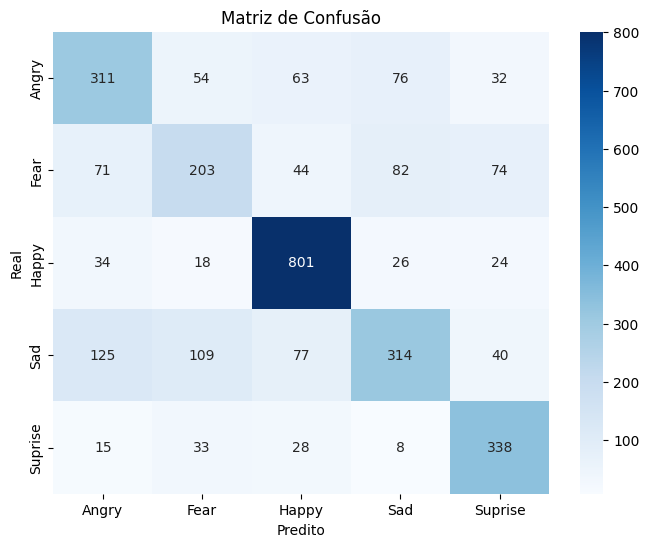

In [83]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)

# Demo

In [84]:
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

def predict_emotion(img_path, model, transform, class_names):
    model.eval()

    # abre imagem e garante 3 canais (RGB)
    img = Image.open(img_path).convert("RGB")

    # aplica os mesmos transforms do conjunto de teste
    img_t = transform(img)
    img_t = img_t.unsqueeze(0).to(device)   # [1, C, H, W]

    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    predicted_class = class_names[pred_idx.item()]
    confidence = conf.item()

    return predicted_class, confidence, img

Emoção prevista: Happy (93.20% de confiança)


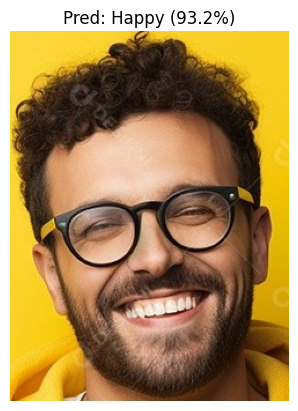

In [85]:
class_names = base_dataset.classes

img_path = "/content/happy_cropped.jpg"   # muda para o caminho da tua imagem

pred, conf, img = predict_emotion(img_path, resnet, transform_test, class_names)

print(f"Emoção prevista: {pred} ({conf*100:.2f}% de confiança)")

plt.imshow(img)
plt.title(f"Pred: {pred} ({conf*100:.1f}%)")
plt.axis("off")
plt.show()